<a href="https://colab.research.google.com/github/mrsKalkan/GitHub-Categorical-ConvNeXtSmall-with-Confusion/blob/main/GitHub_Categorical_ConvNeXtSmall_with_Confusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GPU Info**


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 31 16:30:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-304a16f7-2d3d-9151-aaca-2604e7fadda0)


**CPU Info**

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


**Google Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Package Installs And Imports**

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 37.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import tensorflow as tf
import tensorflow_addons as tfa
import PIL
import PIL.Image
from random import randint

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
print(tf.__version__)

2.12.0


**Load Dataset From Google Drive**


In [ ]:
WEIGHTS_PATH = "/content/drive/My Drive/Saved Weights/Cloud Type/ConvNextSmall/cloud_type_convnextsmall"

In [ ]:
PATH = "/content/drive/My Drive/Cloud-Classification"
file_types = ('*.jpg', '*.jpeg', '*.png')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

dataset = tf.keras.preprocessing.image_dataset_from_directory(PATH,
                                      shuffle=True,
                                      label_mode='categorical',
                                      batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE)

Found 2543 files belonging to 11 classes.


**Classes**

In [ ]:
class_names = dataset.class_names
num_classes = len(class_names)
print(num_classes)
print(class_names)

11
['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St']


**Samples From Dataset**

*   Image
*   Class

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
 for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   plt.imshow(images[i].numpy().astype("uint8"))
   plt.title(class_names[labels[i]])
   plt.axis("off")

**Prepare Train/Validation/Test Datasets**

In [ ]:
# Defining a function for the train, validation, and test split.

def get_dataset_partitions_tf(ds, ds_size, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [ ]:
# Split the dataset into train, validation and test sets.
# Call the function get_dataset_partitions_pd

train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset, ds_size=len(dataset))

print('Size of training dataset batch: %d' % len(train_dataset))
print('Size of validation dataset batch: %d' % len(validation_dataset))
print('Size of test dataset batch: %d' % len(test_dataset))

Size of training dataset batch: 56
Size of validation dataset batch: 16
Size of test dataset batch: 8


**Setting Prefetch**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

**Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.2,0.5)
])

**Samples From Data Augmentation**

In [ ]:
for image, _ in train_dataset.take(1):
 plt.figure(figsize=(10, 10))
 first_image = image[0]
 for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
   plt.imshow(augmented_image[0] / 255)
   plt.axis('off')

**Fetching ConvNextSmall Pre-Trained Model**

In [ ]:
# Create the base model from the pre-trained model EfficientNetV2L
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.convnext.ConvNeXtSmall(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

198551472/198551472 [==============================] - 11s 0us/step


**Shapes Of Features Extracted**

In [ ]:
image_batch, label_batch = train_dataset.as_numpy_iterator().next()
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 768)


**Trainable Variables**

In [ ]:
base_model.trainable = True

In [ ]:
len(base_model.trainable_variables)

342

**Freezeout Fine Tuning**

In [ ]:
# Let's take a look to see how many layers are in the base model
base_layer_count = len(base_model.layers)
print("Number of layers in the base model: ", base_layer_count)

# Fine-tune from this layer onwards
fine_tune_at = int(base_layer_count * (1 / 3))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  295


In [ ]:
len(base_model.trainable_variables)

223

**Base Model Summary**

In [ ]:
base_model.summary()

Model: "convnext_small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_small_prestem_normali  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 zation (Normalization)                                                                           
                                                                                                  
 convnext_small_stem (Sequentia  (None, 56, 56, 96)  4896        ['convnext_small_prestem_normaliz
 l)                                                              ation[0][0]']       

**Pooling Layer**

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 768)


**Prediction Layer**

In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 11)


**Building The Main Model Layers**

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

**Compiling The Main Model**

Includes evaluation metrics

In [ ]:
def build_metrics(no_of_classes):
  metrics = []
  metrics.append('accuracy')
  for i in range(0, no_of_classes):
    metric_name = '{}{}'.format('precision', i)
    metrics.append(tf.keras.metrics.Precision(class_id=i, name=metric_name))

  for i in range(0, no_of_classes):
    metric_name = '{}{}'.format('recall', i)
    metrics.append(tf.keras.metrics.Recall(class_id=i, name=metric_name))

  metrics.append(tf.keras.metrics.AUC(curve='ROC', name='roc_auc', multi_label=True, num_labels=no_of_classes))
  metrics.append(tfa.metrics.MultiLabelConfusionMatrix(num_classes=no_of_classes))
  return metrics

In [ ]:
metrics = build_metrics(num_classes)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 convnext_small (Functional)  (None, 7, 7, 768)        49454688  
                                                                 
 global_average_pooling2d (G  (None, 768)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                             

**Check The Main Model's Accuracy Before Training**

In [ ]:
def get_precision_evaluation(history):
  precision = 0.0
  precision_begin = 2
  precision_end = precision_begin + num_classes
  for i in range(precision_begin, precision_end):
    precision += history[i]

  return precision / num_classes

def get_recall_evaluation(history):
  recall = 0.0
  recall_begin = 2 + num_classes
  recall_end = recall_begin + num_classes
  for i in range(recall_begin, recall_end):
    recall += history[i]

  return recall / num_classes

def get_f1_score(precision, recall):
  f1_score = 0.0
  if (precision + recall) != 0:
    f1_score = (2 * precision * recall) / (precision + recall)

  return f1_score

In [ ]:
initial_history = model.evaluate(validation_dataset)

initial_precision = get_precision_evaluation(initial_history)
initial_recall = get_recall_evaluation(initial_history)
initial_f1_score = get_f1_score(initial_precision, initial_recall)
initial_roc_auc_index = 2 + (2 * num_classes)

print("Initial loss: {:.2f}".format(initial_history[0]))
print("Initial accuracy: {:.2f}".format(initial_history[1]))
print("Initial precision: {:.2f}".format(initial_precision))
print("Initial recall: {:.2f}".format(initial_recall))
print("Initial F1 score: {:.2f}".format(initial_f1_score))
print("Initial ROC: {:.2f}".format(initial_history[initial_roc_auc_index]))

16/16 [==============================] - 23s 390ms/step - loss: 3.0691 - accuracy: 0.0684 - precision0: 0.0000e+00 - precision1: 0.0000e+00 - precision2: 0.0000e+00 - precision3: 0.0000e+00 - precision4: 0.0000e+00 - precision5: 0.0000e+00 - precision6: 0.0000e+00 - precision7: 0.0224 - precision8: 0.0000e+00 - precision9: 0.0000e+00 - precision10: 0.0000e+00 - recall0: 0.0000e+00 - recall1: 0.0000e+00 - recall2: 0.0000e+00 - recall3: 0.0000e+00 - recall4: 0.0000e+00 - recall5: 0.0000e+00 - recall6: 0.0000e+00 - recall7: 0.1000 - recall8: 0.0000e+00 - recall9: 0.0000e+00 - recall10: 0.0000e+00 - roc_auc: 0.4850
Initial loss: 3.07
Initial accuracy: 0.07
Initial precision: 0.00
Initial recall: 0.01
Initial F1 score: 0.00
Initial ROC: 0.48


**Load Weights Or Train The Main Model**

If weights are saved, load them from Google Drive. If not, then train the main model.

**Load Weights**

In [ ]:
model.load_weights(WEIGHTS_PATH)

**Train The Main Model**

In [ ]:
initial_epochs = 100

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
56/56 [==============================] - 91s 532ms/step - loss: 2.0659 - accuracy: 0.2901 - precision0: 0.5000 - precision1: 1.0000 - precision2: 0.4857 - precision3: 0.5965 - precision4: 1.0000 - precision5: 0.5000 - precision6: 1.0000 - precision7: 0.5000 - precision8: 0.5333 - precision9: 0.5333 - precision10: 0.0000e+00 - recall0: 0.0062 - recall1: 0.0145 - recall2: 0.1012 - recall3: 0.1828 - recall4: 0.0385 - recall5: 0.0098 - recall6: 0.2537 - recall7: 0.0082 - recall8: 0.0460 - recall9: 0.0675 - recall10: 0.0000e+00 - roc_auc: 0.7221 - Multilabel_confusion_matrix: 443.7500 - val_loss: 1.6103 - val_accuracy: 0.4465 - val_precision0: 1.0000 - val_precision1: 0.0000e+00 - val_precision2: 0.8667 - val_precision3: 0.8333 - val_precision4: 0.5000 - val_precision5: 0.6000 - val_precision6: 1.0000 - val_precision7: 0.7500 - val_precision8: 0.5000 - val_precision9: 0.5882 - val_precision10: 0.0000e+00 - val_recall0: 0.0233 - val_recall1: 0.0000e+00 - val_recall2: 0.4906 - val

**Save Weights**

If training is done, then save the weights to Google Drive.

In [ ]:
model.save_weights(WEIGHTS_PATH)

**Prepare Evaluation Metrics History Of Training**

In [ ]:
def get_precision_histories(history):
  precision_history = [0] * initial_epochs
  val_precision_history = [0] * initial_epochs
  for i in range(0, num_classes):
    metric_name = '{}{}'.format('precision', i)
    val_metric_name = 'val_' + metric_name
    precision_history = [sum(x) for x in zip(precision_history, history.history[metric_name])]
    val_precision_history = [sum(x) for x in zip(precision_history, history.history[val_metric_name])]

  for i in range(0, initial_epochs):
    precision_history[i] = precision_history[i] / num_classes
    val_precision_history[i] = val_precision_history[i] / num_classes

  return precision_history, val_precision_history

def get_recall_histories(history):
  recall_history = [0] * initial_epochs
  val_recall_history = [0] * initial_epochs
  for i in range(0, num_classes):
    metric_name = '{}{}'.format('recall', i)
    val_metric_name = 'val_' + metric_name
    recall_history = [sum(x) for x in zip(recall_history, history.history[metric_name])]
    val_recall_history = [sum(x) for x in zip(recall_history, history.history[val_metric_name])]

  for i in range(0, initial_epochs):
    recall_history[i] = recall_history[i] / num_classes
    val_recall_history[i] = val_recall_history[i] / num_classes

  return recall_history, val_recall_history

def calculate_f1_scores(precision, recall, val_precision, val_recall):
  f1_score_temp = np.empty(len(precision))
  val_f1_score_temp = np.empty(len(f1_score_temp))
  for i in range(len(precision)):
    harmonic_avg = 0.0
    if (precision[i] + recall[i]) != 0:
      harmonic_avg = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])

    val_harmonic_avg = 0.0
    if (val_precision[i] + val_recall [i]) != 0:
      val_harmonic_avg = (2 * val_precision[i] * val_recall [i]) / (val_precision[i] + val_recall [i])

    np.put(f1_score_temp, i, harmonic_avg)
    np.put(val_f1_score_temp, i, val_harmonic_avg)
  return [f1_score_temp, val_f1_score_temp]

In [ ]:
metric_name_loss = model.metrics_names[0]
metric_name_accuracy = model.metrics_names[1]

In [ ]:
acc = history.history[metric_name_accuracy]
val_acc = history.history['val_' + metric_name_accuracy]

loss = history.history[metric_name_loss]
val_loss = history.history['val_' + metric_name_loss]

roc_auc = history.history['roc_auc']
val_roc_auc = history.history['val_roc_auc']

precision, val_precision = get_precision_histories(history)

recall, val_recall = get_recall_histories(history)

f1_score, val_f1_score = calculate_f1_scores(precision, recall, val_precision, val_recall)

**Learning Curves**

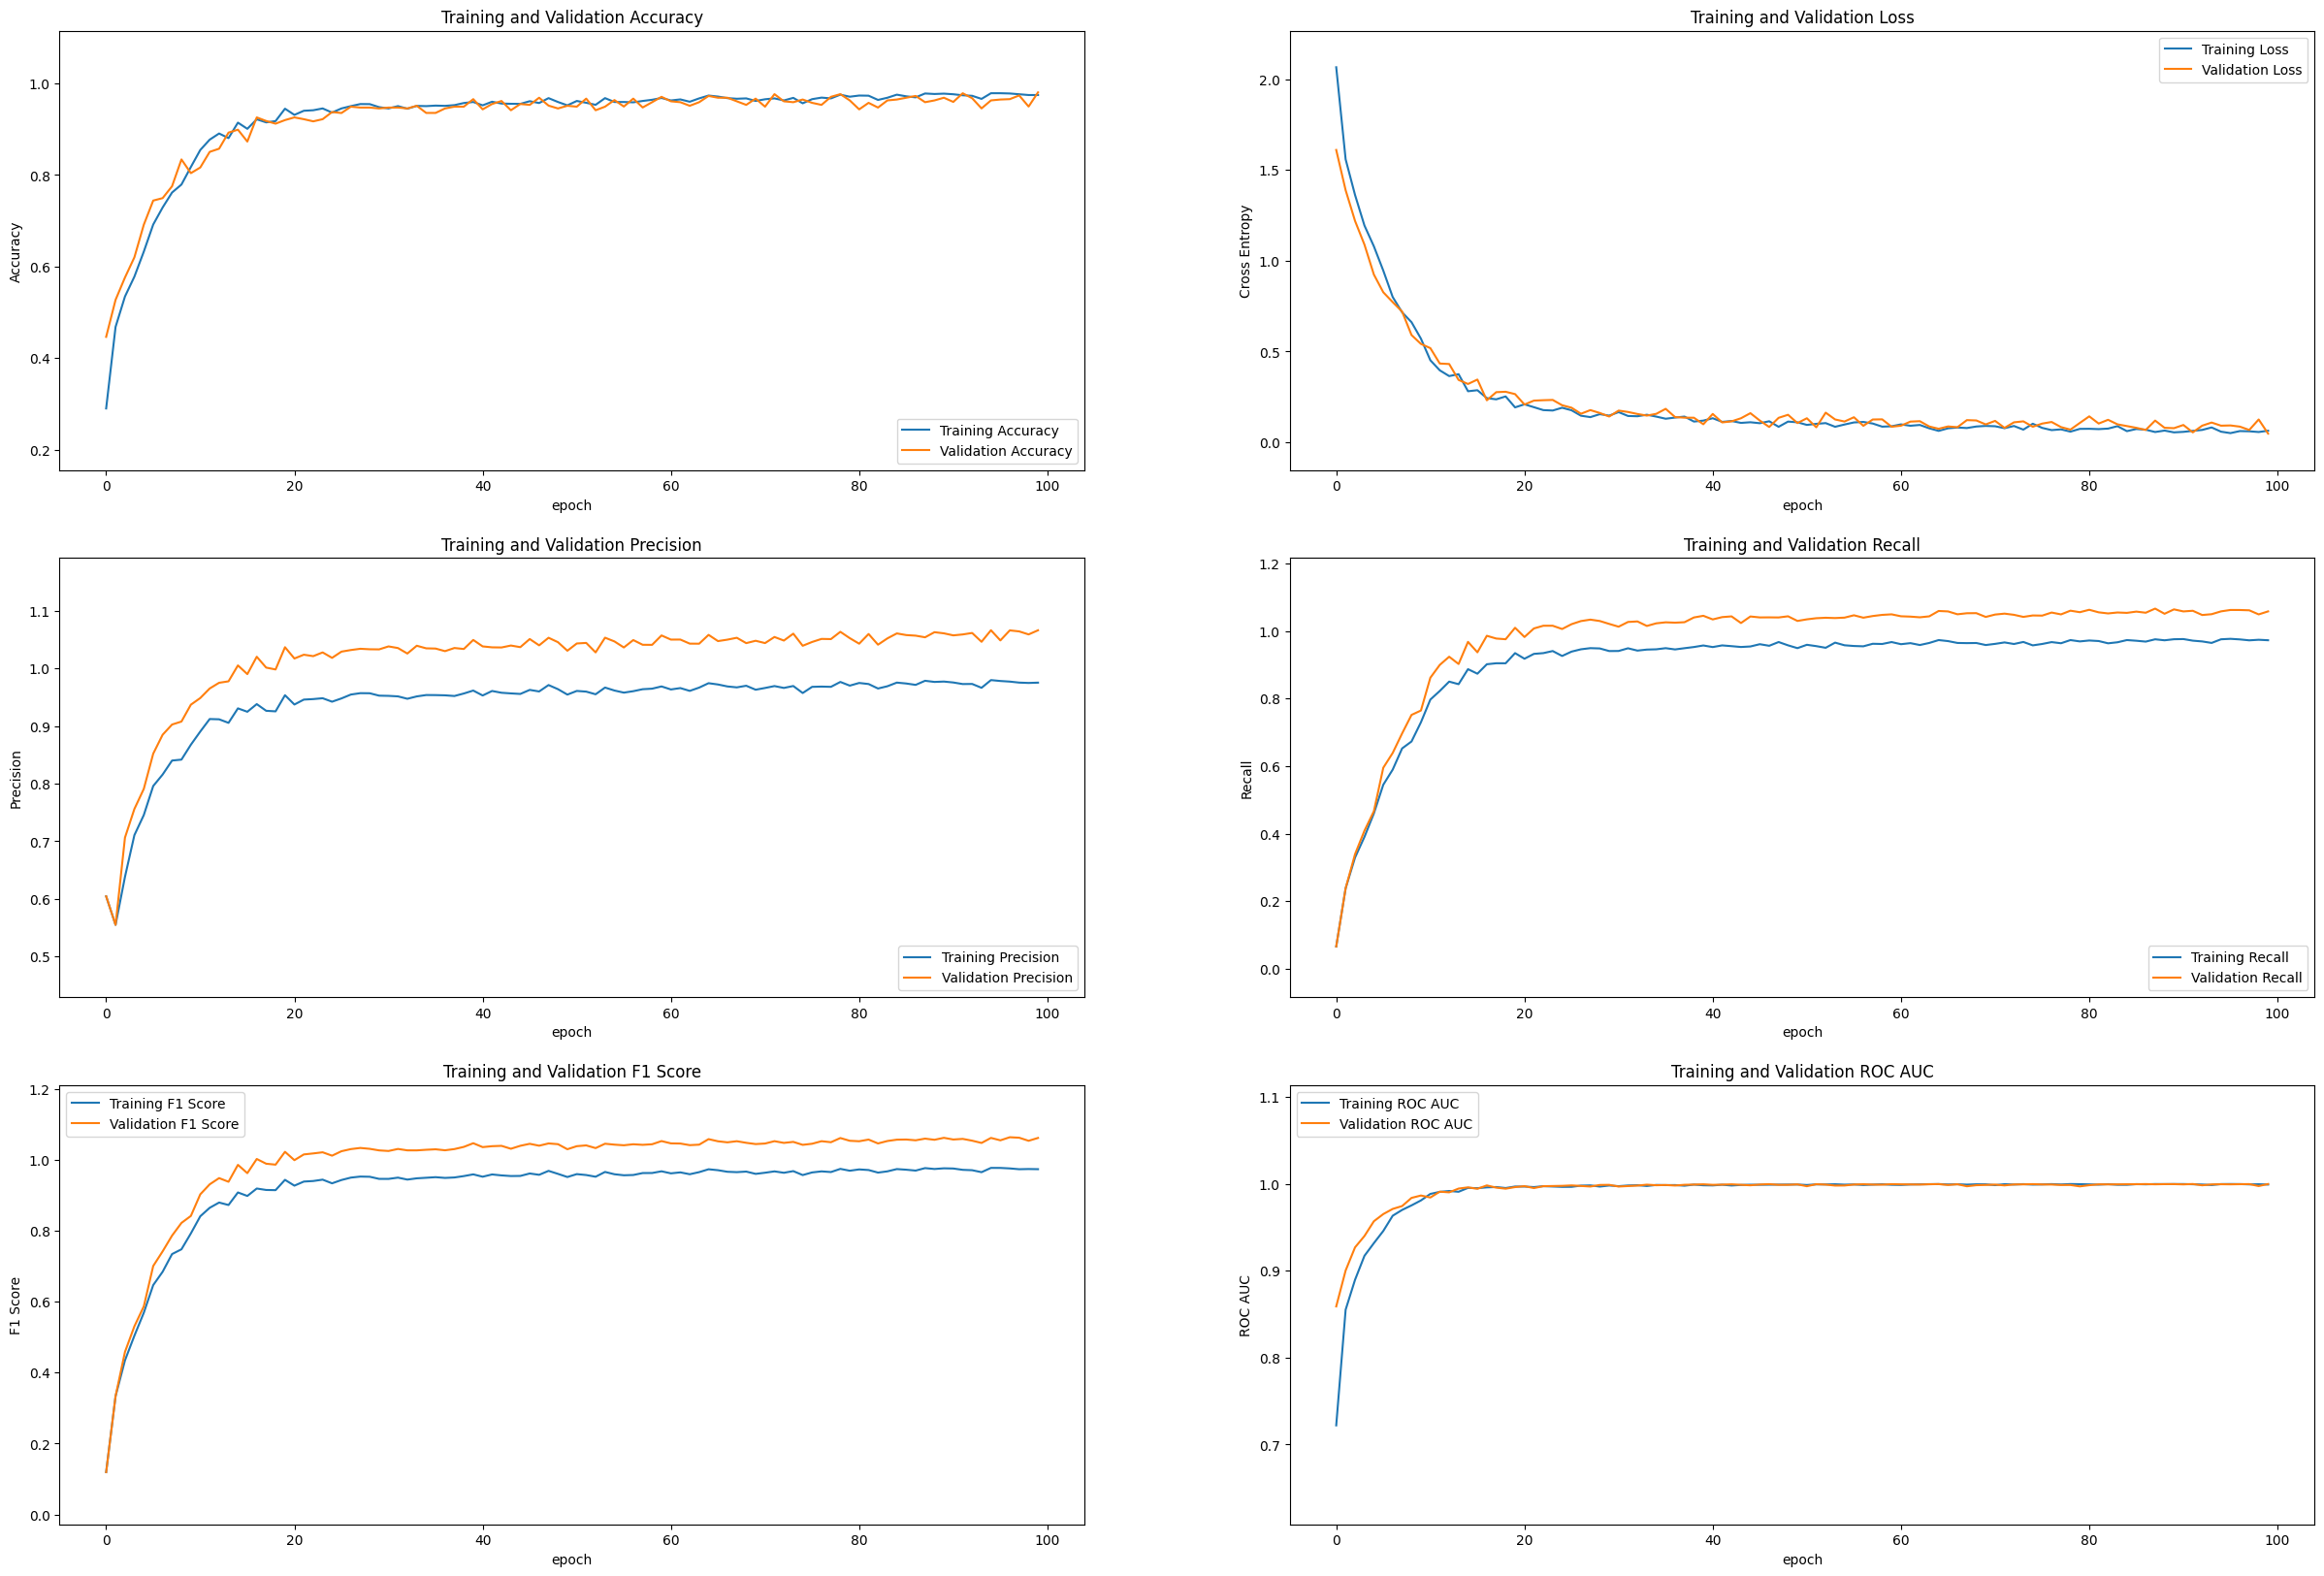

In [ ]:
plt.figure(figsize=(30, 20))

plt.subplot(3, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(3, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 2, 3)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

plt.subplot(3, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation Recall')
plt.xlabel('epoch')

plt.subplot(3, 2, 5)
plt.plot(f1_score, label='Training F1 Score')
plt.plot(val_f1_score, label='Validation F1 Score')
plt.legend(loc='upper left')
plt.ylabel('F1 Score')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation F1 Score')
plt.xlabel('epoch')

plt.subplot(3, 2, 6)
plt.plot(roc_auc, label='Training ROC AUC')
plt.plot(val_roc_auc, label='Validation ROC AUC')
plt.legend(loc='upper left')
plt.ylabel('ROC AUC')
plt.ylim([min(plt.ylim()) - 0.1, max(plt.ylim()) + 0.1])
plt.title('Training and Validation ROC AUC')
plt.xlabel('epoch')

plt.show()

**Final Evaluation Of The Trained Model Against Test Dataset**

In [ ]:
test_results = model.evaluate(test_dataset)

8/8 [==============================] - 2s 86ms/step - loss: 0.1160 - accuracy: 0.9648 - precision0: 1.0000 - precision1: 1.0000 - precision2: 1.0000 - precision3: 0.9355 - precision4: 0.9412 - precision5: 0.9583 - precision6: 1.0000 - precision7: 1.0000 - precision8: 0.9062 - precision9: 0.9730 - precision10: 1.0000 - recall0: 0.9048 - recall1: 0.9286 - recall2: 1.0000 - recall3: 0.9667 - recall4: 1.0000 - recall5: 0.9200 - recall6: 0.9643 - recall7: 1.0000 - recall8: 1.0000 - recall9: 0.9730 - recall10: 0.9000 - roc_auc: 0.9961 - Multilabel_confusion_matrix: 64.0000


In [ ]:
test_precision = get_precision_evaluation(test_results)
test_recall = get_recall_evaluation(test_results)
test_f1_score = get_f1_score(test_precision, test_recall)
test_roc_auc_index = 2 + (2 * num_classes)

print("Test loss: {}".format(test_results[0]))
print("Test accuracy: {}".format(test_results[1]))
print("Test precision: {}".format(test_precision))
print("Test recall: {}".format(test_recall))
print("Test F1 score: {}".format(test_f1_score))
print("Test ROC: {}".format(test_results[test_roc_auc_index]))

Test loss: 0.11595109105110168
Test accuracy: 0.96484375
Test precision: 0.9740196954120289
Test recall: 0.9597507877783342
Test F1 score: 0.9668325978800073
Test ROC: 0.9961487054824829


**Multi-Class Confusion Matrices**

In [ ]:
images_test = []
labels_test = []

for batch in test_dataset:
  image_batch, label_batch = batch
  for i in image_batch:
    images_test.append(i)

  for i in label_batch:
    labels_test.append(i)

images_test = np.array(images_test)
labels_test = np.array(labels_test)
predictions = model.predict_on_batch(images_test)

In [ ]:
def get_highest_label(label_arr):
  max_num = -1
  max_index = -1
  for i in range(0, num_classes):
    if label_arr[i] > max_num:
      max_num = label_arr[i]
      max_index = i

  return max_index

In [ ]:
labelMapFunc = lambda x: get_highest_label(x)
labels_test_single = np.array([labelMapFunc(xi) for xi in labels_test])
predictions_test_single = np.array([labelMapFunc(xi) for xi in predictions])

In [ ]:
labels_test_single

array([ 1,  3,  5,  0,  7,  6,  5,  0,  4,  2, 10,  7,  4,  3,  8,  8,  5,
        2,  3,  8,  4,  0,  4,  1,  0,  2,  2,  0,  3,  2, 10,  5,  5,  3,
        5,  3,  1, 10,  1,  5,  1,  4, 10,  0,  4,  7,  9,  1, 10,  6,  7,
        0,  9,  5,  5,  3,  2,  5,  0,  8,  8,  6, 10,  8,  6,  8,  8,  8,
        7,  8,  4, 10, 10,  5,  1,  7,  1,  2,  8,  8,  7,  5,  9,  3,  6,
        1,  8,  8,  9,  0,  4,  9,  2,  6,  0,  0,  4,  7,  5,  0, 10,  4,
        0,  9,  1, 10,  0, 10,  9,  6,  2,  0,  3,  4,  9,  4,  4,  3,  6,
        5,  9, 10,  2,  8,  7,  2,  2,  9,  3,  4,  9,  5,  0,  9,  2,  0,
        3,  6,  0,  6,  8,  5,  9,  2,  9,  5, 10,  3,  3,  8,  7,  6,  9,
        8,  1,  1,  0,  5,  0,  1,  8,  0,  8,  3,  8,  3,  5,  1,  0,  9,
        8,  6,  8, 10,  3,  6,  7,  6,  3,  2,  4,  4,  9,  0,  0,  0, 10,
       10,  5,  0,  6, 10,  3,  5,  2,  7,  9,  7,  8,  9,  9,  3,  0,  7,
        1,  1, 10,  9,  0,  7,  3, 10,  7,  9,  2,  0,  9, 10,  5,  6,  9,
        9,  0,  7,  7,  3

In [ ]:
predictions_test_single

array([ 1,  5,  5,  0,  7,  6,  5,  0,  4,  2, 10,  7,  4,  3,  8,  8,  5,
        2,  3,  8,  5,  0,  4,  1,  0,  2,  2,  0,  3,  2, 10,  5,  5,  3,
        5,  3,  1, 10,  1,  5,  1,  4, 10,  0,  4,  7, 10,  1, 10,  6,  7,
        0,  9,  5,  5,  3,  2,  5,  0,  8,  8,  6, 10,  8,  6,  8,  8,  8,
        7,  8,  4, 10, 10,  5,  1,  7,  1,  2,  8,  8,  7,  5,  9,  3,  6,
        1,  8,  8,  9,  0,  4,  9,  2,  6,  3,  0,  4,  7,  5,  0,  4,  4,
        0,  9,  1, 10,  0, 10,  9,  6,  2,  0,  3,  4,  9,  4,  4,  3,  6,
        5,  9,  8,  2,  8,  7,  2,  2,  9,  3,  4,  9,  5,  0,  9,  2,  0,
        3,  6,  0,  6,  8,  5,  9,  2,  8,  5, 10,  3,  3,  8,  7,  6,  9,
        8,  1,  1,  0,  5,  0,  4,  8,  0,  8,  3,  8,  3,  5,  1,  0,  9,
        8,  6,  8, 10,  8,  6,  7,  6,  3,  2,  4,  4,  9,  0,  0,  0, 10,
       10,  5,  0,  6,  1,  3,  5,  2,  7,  9,  7,  8,  9,  9,  3,  0,  7,
        1,  1, 10,  9,  0,  7,  3, 10,  7,  9,  2,  0,  9, 10,  5,  6,  9,
        9,  0,  2,  7,  5

In [ ]:
multi_class_confusion_matrix = []
for i in range(0, num_classes):
  row = [0] * num_classes
  multi_class_confusion_matrix.append(row)

for i in range(0, len(labels_test_single)):
  actual = labels_test_single[i]
  pred = predictions_test_single[i]

  multi_class_confusion_matrix[actual][pred] = multi_class_confusion_matrix[actual][pred] + 1

multi_class_confusion_matrix

[[30, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 15, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 21, 0, 2, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 15, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 19, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 28, 1],
 [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 18]]

In [ ]:
def print_matrix(matrix):
  s = ''
  for i in range(0, len(matrix)):
    for j in range(0, len(matrix[0])):
      s = s + '\t' + str(matrix[i][j])
    s = s + '\n'

  print(s)

In [ ]:
print_matrix(multi_class_confusion_matrix)

	30	0	0	1	0	0	0	0	0	0	0
	0	15	0	0	1	0	0	0	0	0	0
	0	0	22	0	0	0	0	0	0	0	0
	1	0	0	21	0	2	0	0	1	0	0
	0	0	0	0	15	1	0	0	0	0	0
	0	0	0	0	0	25	0	0	0	0	0
	0	0	0	0	0	0	20	0	0	0	0
	0	0	1	0	0	0	0	19	0	0	0
	0	0	0	0	0	0	0	0	30	0	0
	0	0	0	0	0	0	0	0	1	28	1
	0	1	0	0	1	0	0	0	1	0	18



**Samples From Predicted Test Dataset**

*   Image
*   Predicted class with its prediction probability
*   Actual Class

In [ ]:
print('test size: ', len(test_dataset))

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
print('image_batch size: ', len(image_batch))
print('label_batch size: ', len(label_batch))
print('label_batch example: ', label_batch[0])

predictions = model.predict_on_batch(image_batch)
print('predictions size: ', len(predictions))
print('predictions example: ', predictions[0])

test size:  8
image_batch size:  32
label_batch size:  32
label_batch example:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predictions size:  32
predictions example:  [7.2990108e-04 9.9825948e-01 1.5182688e-05 8.2283786e-06 1.6818411e-04
 3.9153142e-04 1.4883264e-05 5.0884624e-05 2.0591634e-04 3.9121023e-06
 1.5187693e-04]


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  img = img[i]
  true_label = true_label[i]
  true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.astype("uint8"))

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks(range(num_classes), class_names)
  plt.yticks([])
  thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
def generate_random_indices(max_number, size):
  result = []
  random_number = randint(0, max_number - 1)
  while len(result) < size:
    while random_number in result:
      random_number = randint(0, max_number - 1)

    result.append(random_number)

  return result

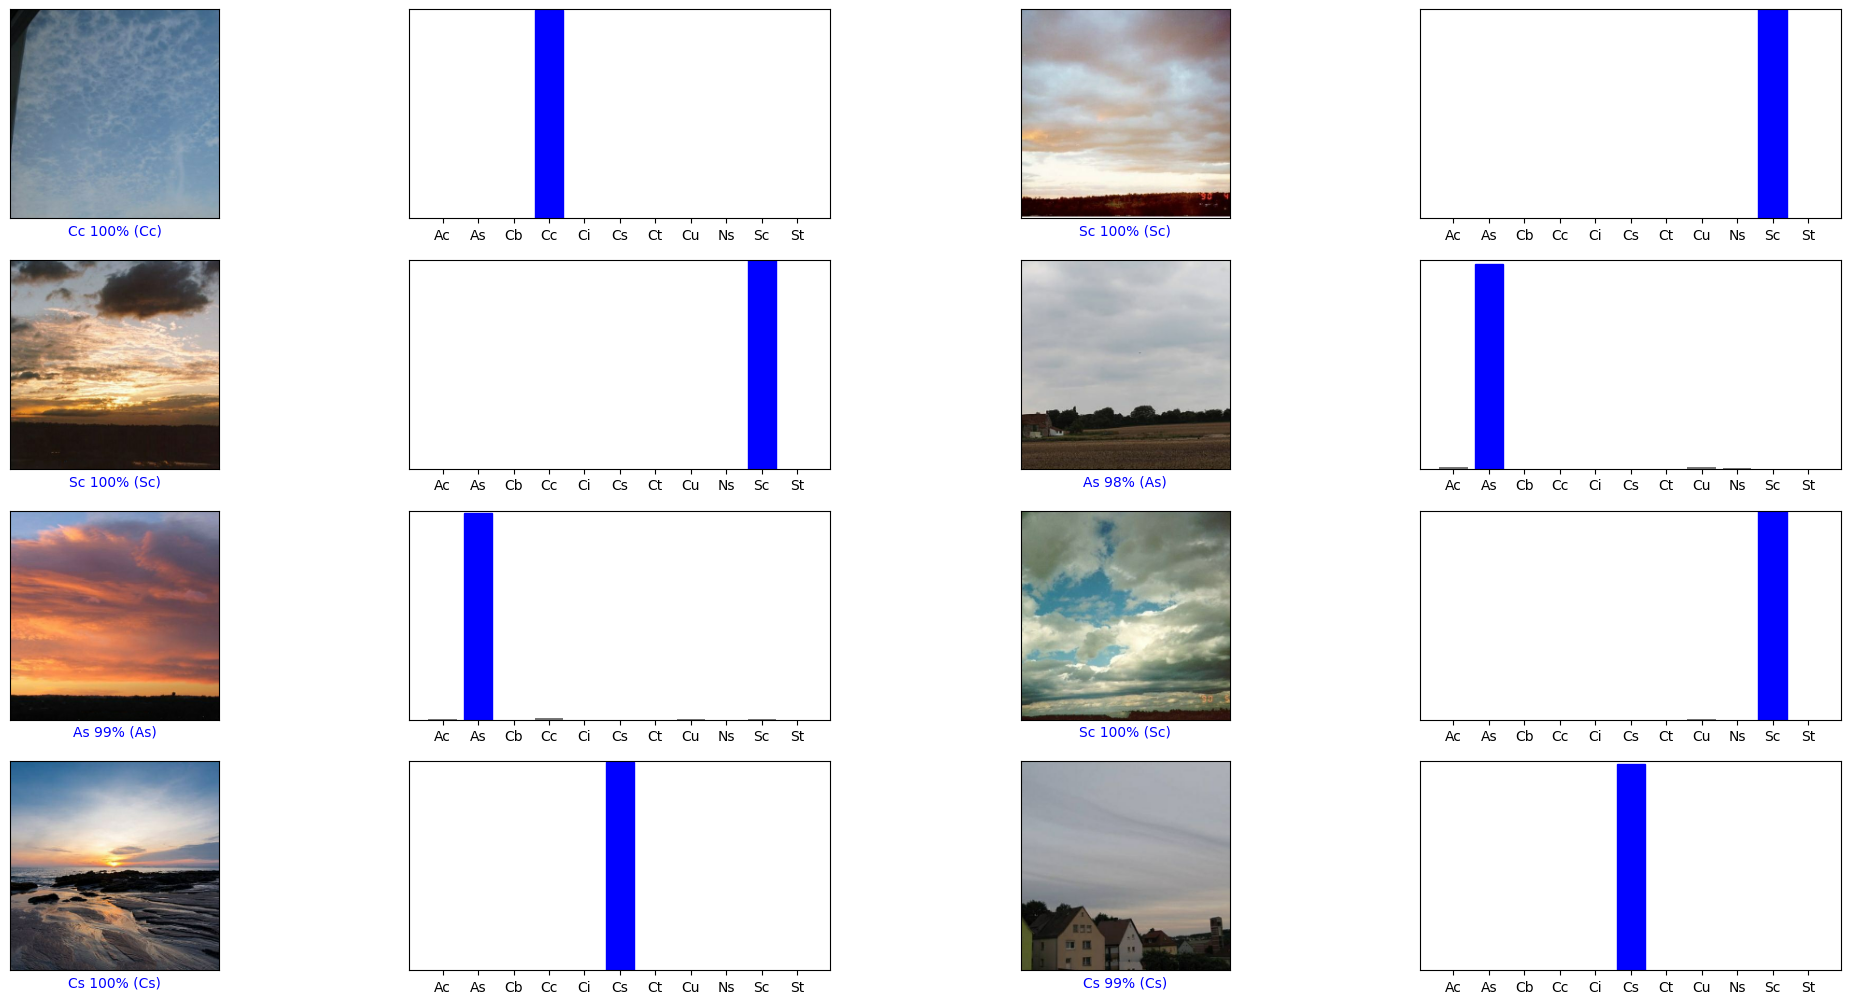

In [ ]:
row_count = 4
col_count = 2
img_view_size = row_count * col_count

indices = generate_random_indices(len(image_batch), img_view_size)

plt.figure(figsize=(12.5 * col_count, 3.12 * row_count))
for j in range(0, img_view_size):
  i = indices[j]

  #display image
  plt.subplot(row_count, 2 * col_count, 2 * j + 1)
  plot_image(i, predictions[i], label_batch, image_batch)

  #display prediction bar graph
  plt.subplot(row_count, 2 * col_count, (2 * j) + 2)
  plot_value_array(i, predictions[i],  label_batch)

plt.show()